In [ ]:
!pip install opendatasets
import opendatasets as od

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dataset_url='https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vishal0501
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:19<00:00, 21.7MB/s]


In [ ]:
import os
Data_Dir='./animefacedataset'
# print(os.listdir(Data_Dir+'/images'))

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size=64
batch_size=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [ ]:
train_ds=ImageFolder(Data_Dir,transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=2, pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [ ]:
print(stats[0][0])

0.5


In [ ]:
def denorm(img_tensors):
  return img_tensors*stats[1][0] + stats[0][0]

def show_images(images,nmax=64):
  fig,ax=plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl,nmax=64):
  for images,_ in dl:
    # print(images)
    show_images(images,nmax)
    break

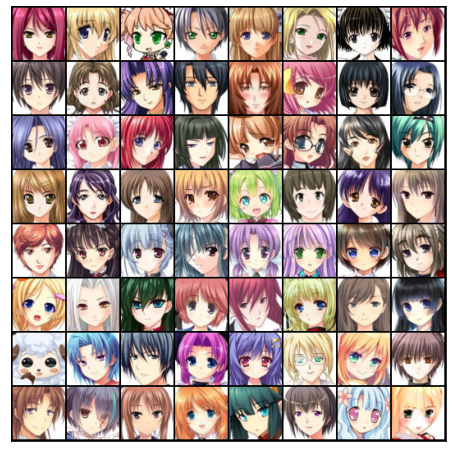

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device=get_default_device()
device

device(type='cuda')

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)

In [ ]:
import torch.nn as nn
discriminator=nn.Sequential(
    
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False), #3x64x64
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    # nn.ReLU(inplace=True),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), #64x32x32
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # nn.ReLU(inplace=True),
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # in 128x16x16
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # nn.ReLU(inplace=True),
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), # in 256x8x8
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # nn.ReLU(inplace=True),
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), #512x4x4
    #out 1x1x1
    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator=to_device(discriminator,device)

In [ ]:
latent_size=128
generator=nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True), #512x4x4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True), #256x8x8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True), #128x16x16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True), #64x32x32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh() #3x64x64
)

torch.Size([128, 3, 64, 64])


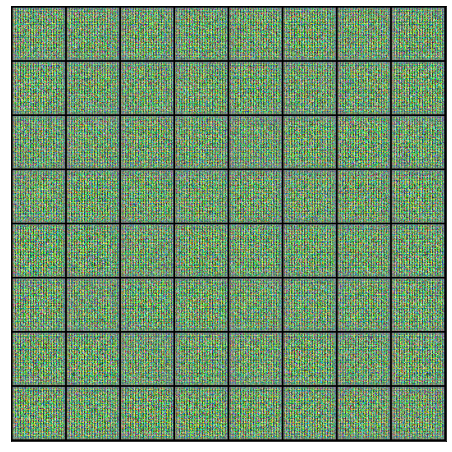

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator= to_device(generator,device)

In [ ]:
import torch.nn.functional as F

def train_discriminator(real_images,opt_d):
  opt_d.zero_grad()

  real_preds=discriminator(real_images)
  real_targets=torch.ones(real_images.size(0) ,1, device=device)
  real_loss=F.binary_cross_entropy(real_preds, real_targets)
  real_score=torch.mean(real_preds).item()

  latent_vector = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent_vector)

  fake_targets=torch.zeros(fake_images.size(0),1,device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss=real_loss+fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(),real_score,fake_score


In [ ]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent=torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images=generator(latent)

  preds=discriminator(fake_images)
  targets=torch.ones(batch_size,1,device=device)
  loss=F.binary_cross_entropy(preds,targets)
  loss.backward()
  opt_g.step()
  
  return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir='generated'
os.makedirs('generated',exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


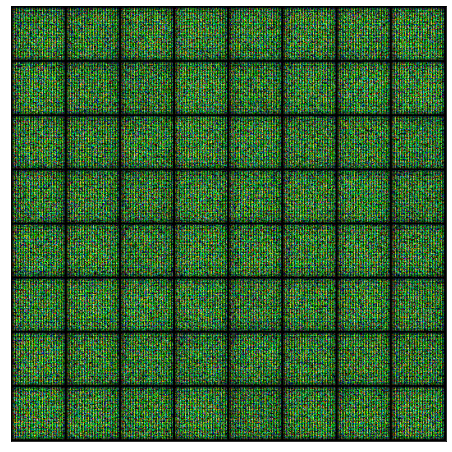

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm

def fit(epochs,lr,start_idx=1):
  torch.cuda.empty_cache()
  losses_g=[]
  losses_d=[]
  real_scores=[]
  fake_scores=[]

  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
  return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 30

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 6.1426, loss_d: 0.6654, real_score: 0.9617, fake_score: 0.4272
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 6.7287, loss_d: 0.7371, real_score: 0.9409, fake_score: 0.4552
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 5.7944, loss_d: 0.3753, real_score: 0.9795, fake_score: 0.2804
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 3.3614, loss_d: 0.1954, real_score: 0.9454, fake_score: 0.1118
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 4.4614, loss_d: 0.1607, real_score: 0.9311, fake_score: 0.0781
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 2.7197, loss_d: 0.5297, real_score: 0.6606, fake_score: 0.0153
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 7.1975, loss_d: 0.0281, real_score: 0.9959, fake_score: 0.0231
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 3.1252, loss_d: 0.2040, real_score: 0.8515, fake_score: 0.0264
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 4.5986, loss_d: 0.3890, real_score: 0.8659, fake_score: 0.1735
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 5.2874, loss_d: 0.1409, real_score: 0.9373, fake_score: 0.0648
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 5.1257, loss_d: 0.2649, real_score: 0.9954, fake_score: 0.2098
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 4.9857, loss_d: 0.1110, real_score: 0.9716, fake_score: 0.0700
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 5.0055, loss_d: 0.2925, real_score: 0.7788, fake_score: 0.0085
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 4.4200, loss_d: 0.2917, real_score: 0.8785, fake_score: 0.1135
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 5.0939, loss_d: 0.0911, real_score: 0.9633, fake_score: 0.0483
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 5.1374, loss_d: 0.0775, real_score: 0.9599, fake_score: 0.0326
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 3.2576, loss_d: 0.1288, real_score: 0.9190, fake_score: 0.0321
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 1.2258, loss_d: 0.3863, real_score: 0.7263, fake_score: 0.0099
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 3.9667, loss_d: 0.1181, real_score: 0.9413, fake_score: 0.0498
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 4.9046, loss_d: 0.0729, real_score: 0.9878, fake_score: 0.0566
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 5.6945, loss_d: 0.2672, real_score: 0.8101, fake_score: 0.0021
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 8.9217, loss_d: 1.7395, real_score: 0.9994, fake_score: 0.7162
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 5.5379, loss_d: 0.0966, real_score: 0.9721, fake_score: 0.0582
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 5.2645, loss_d: 0.0384, real_score: 0.9842, fake_score: 0.0216
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 5.5360, loss_d: 0.2003, real_score: 0.9766, fake_score: 0.1391
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 5.8171, loss_d: 0.0999, real_score: 0.9792, fake_score: 0.0698
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 4.0459, loss_d: 0.2227, real_score: 0.8969, fake_score: 0.0762
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 4.7598, loss_d: 0.0491, real_score: 0.9683, fake_score: 0.0142
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 8.8011, loss_d: 0.3692, real_score: 0.9956, fake_score: 0.2615
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 4.3257, loss_d: 0.0774, real_score: 0.9877, fake_score: 0.0590
Saving generated-images-0030.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

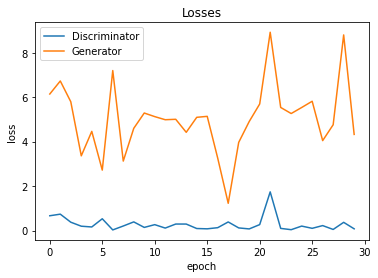

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

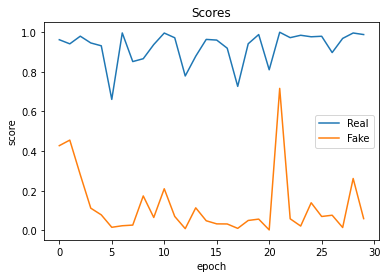

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
from IPython.display import Image

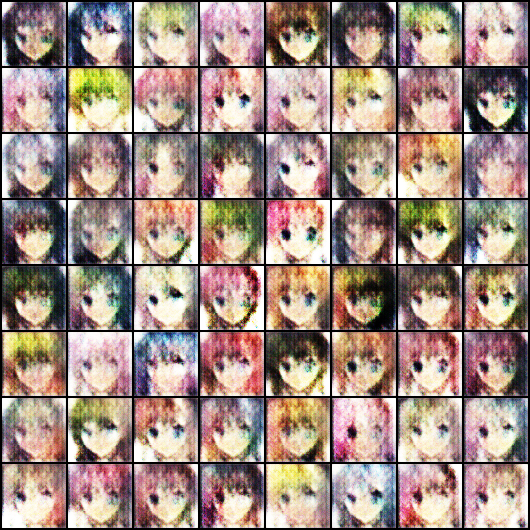

In [ ]:
Image('./generated/generated-images-0001.png')

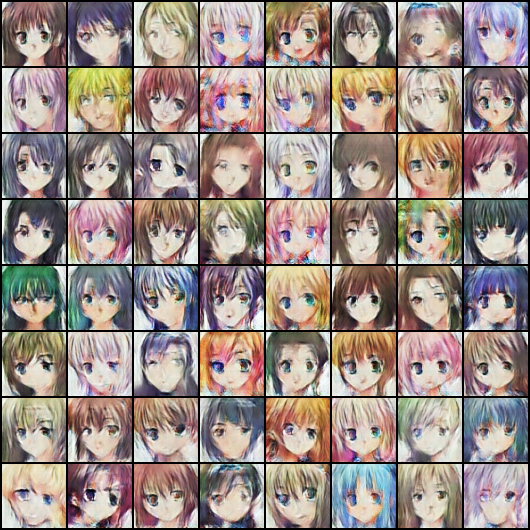

In [ ]:
Image('./generated/generated-images-0010.png')

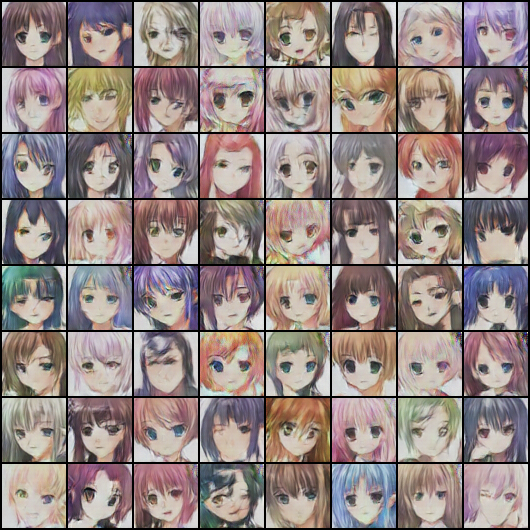

In [ ]:
Image('./generated/generated-images-0020.png')

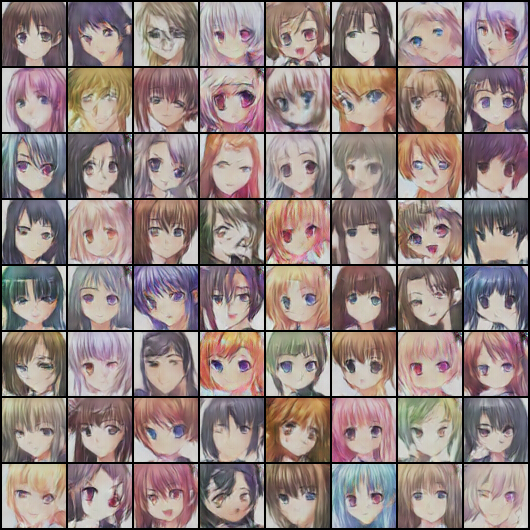

In [ ]:
Image('./generated/generated-images-0025.png')

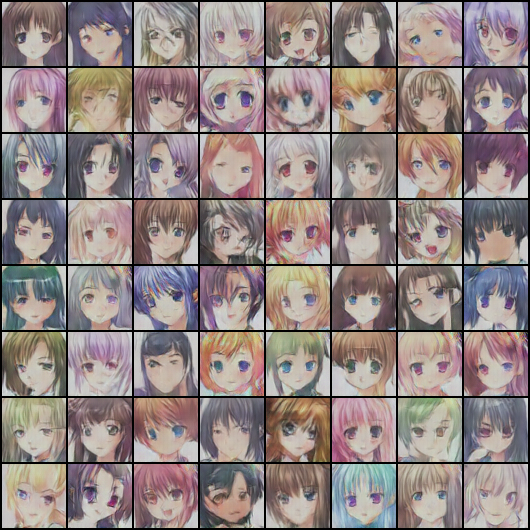

In [ ]:
Image('./generated/generated-images-0030.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
!zip -r /content/generated.zip /content/generated/ 


  adding: content/generated/ (stored 0%)
  adding: content/generated/generated-images-0005.png (deflated 0%)
  adding: content/generated/generated-images-0023.png (deflated 0%)
  adding: content/generated/generated-images-0028.png (deflated 0%)
  adding: content/generated/generated-images-0018.png (deflated 0%)
  adding: content/generated/generated-images-0000.png (deflated 0%)
  adding: content/generated/generated-images-0027.png (deflated 0%)
  adding: content/generated/generated-images-0026.png (deflated 0%)
  adding: content/generated/generated-images-0011.png (deflated 0%)
  adding: content/generated/generated-images-0021.png (deflated 0%)
  adding: content/generated/.ipynb_checkpoints/ (stored 0%)
  adding: content/generated/gans_training.avi (deflated 1%)
  adding: content/generated/generated-images-0029.png (deflated 0%)
  adding: content/generated/generated-images-0020.png (deflated 0%)
  adding: content/generated/generated-images-0002.png (deflated 0%)
  adding: content/gener